In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

In [4]:
len(words)

32033

# Preprocess the data

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [106]:
import torch

# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> (torch.tensor, torch.tensor):
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 5
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)

torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


# Model

In [47]:
EMBED_SZ = 32
HIDDEN_LAYER_SZ = 96
activation = 'leaky_relu'  # relu

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, EMBED_SZ), generator=g)

# Kaiming init
W1 = torch.randn((CONTEXT_SZ * EMBED_SZ, HIDDEN_LAYER_SZ), generator=g).abs()
W1 = torch.nn.init.kaiming_normal_(W1, nonlinearity=activation)
# Bias is disabled since we've added a batchnorm layer
#b1 = torch.randn(HIDDEN_LAYER_SZ, generator=g) * 0.01

W2 = torch.randn((HIDDEN_LAYER_SZ, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch normalizations
bngain = torch.ones((1, HIDDEN_LAYER_SZ))
bnbias = torch.zeros((1, HIDDEN_LAYER_SZ))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# Reset parameters for training
for p in parameters:
    p.requires_grad = True

bnmean_running = torch.zeros((1, HIDDEN_LAYER_SZ))
bnstd_running = torch.ones((1, HIDDEN_LAYER_SZ))

# Total number of parameters
sum(p.nelement() for p in parameters)

19131

# Training

In [60]:
from typing import Union

relu = torch.nn.LeakyReLU() if activation == 'leaky_relu' else torch.nn.ReLU()
#relu = torch.tanh

# Batch normalization momentum for running mean/stdev. Set based on batch size
# based on how much thrashing seen w/ smaller batches
momentum = 0.001

def forward_pass(
        x: torch.tensor,
        bmean: Union[torch.tensor, None] = None,
        bstd: Union[torch.tensor, None] = None,
        stdize=False
) -> torch.tensor:
    """Forward pass."""
    emb = C[x] # (N, CONTEXT_SZ, 2)
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

    # Linear layer
    hpreact = embcat @ W1 # + b1  # Hidden layer pre-activation

    # Batchnorm layer
    if bmean is None:
        bm = hpreact.mean(0, keepdim=True)
        with torch.no_grad():
            global bnmean_running
            bnmean_running = (1-momentum) * bnmean_running + momentum * bm
    else:
        bm = bmean
    if bstd is None:
        bs = hpreact.std(0, keepdim=True)
        with torch.no_grad():
            global bnstd_running
            bnstd_running = (1-momentum) * bnstd_running + momentum * bs
    else:
        bs = bstd
    # TODO: Epsilon can go here
    hpreact = bngain * (hpreact - bm) / bs + bnbias

    # Non-linearity
    h = relu(hpreact)  # hidden layer  # (N, HIDDEN_LAYER_SZ)
    return h @ W2 + b2 # output layer (HIDDEN_LAYER_SZ, 27)

In [55]:
from statistics import mean
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F

MINI_BATCH_SZ = 128

# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -5, steps=50000)])
lrs = 10**lre
#plt.plot(range(0, len(lrs)), lrs)

lri = []
lossi = []
loglossi = []
loglossiavg = []
stepi = []

pbar = tqdm(range(len(lrs)))
for i in pbar:
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,), generator=g) # (MINI_BATCH_SZ)
    Xb, Yb = Xtr[ix], Ytr[ix]

    if i == 0:
        with torch.no_grad():
            # This is repeated here for the exercise of looking at the impact of poor
            # initialization weights with respect to the activation function.
            emb = C[Xb]
            h = emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1

    # Forward pass
    logits = forward_pass(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Update parameters
    lr = lrs[i]
    sgd = torch.optim.SGD(parameters, lr=lr, weight_decay=0.001)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    if i < 500:
        loglossiavg.append(loss.log10().item())
    else:
        loglossiavg.append(mean(loglossi[-500:]))
    if i % 1000 == 0:
        pbar.set_description("LR: %0.4f Loss %0.4f" % (lr, mean(lossi[-500:])))

LR: 0.0000 Loss 1.9853: 100%|██████████| 150000/150000 [01:53<00:00, 1324.35it/s]


Initialization


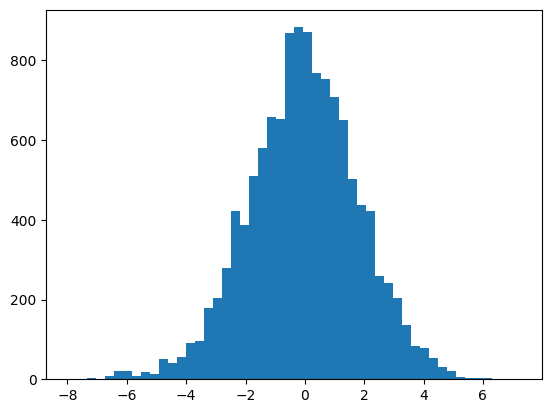

In [13]:
plt.hist(h.view(-1).tolist(), 50)
print("Initialization")

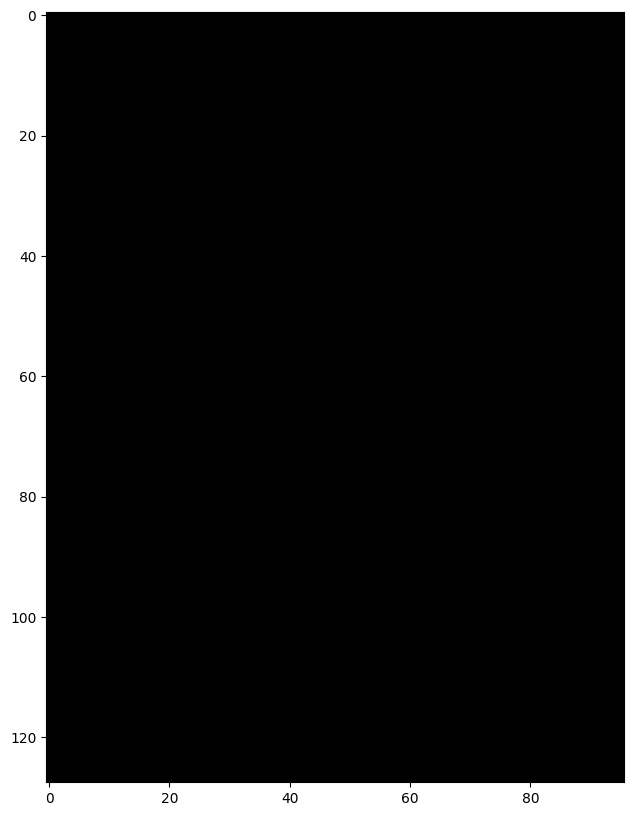

In [64]:
# Visualizing dead neurons
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Evaluate Loss

0.5173748731613159

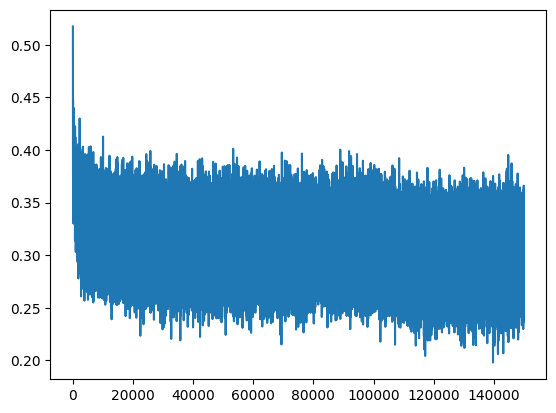

In [15]:
plt.plot(stepi, loglossi)
loglossi[0]

In [16]:
# Expected loss at initialization
-torch.tensor(1/27.0).log()

tensor(3.2958)

# Calibrate the batch norm

In [61]:
print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
    'num_parameters': sum(p.nelement() for p in parameters),
})

with torch.no_grad():
    xtr_loss = F.cross_entropy(forward_pass(Xtr, bnmean_running, bnstd_running), Ytr)
    print(f"Xtr loss: {xtr_loss:0.4f}")

    xdev_loss = F.cross_entropy(forward_pass(Xdev, bnmean_running, bnstd_running), Ydev)
    print(f"Xdev loss: {xdev_loss:0.4f}")

{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 19131}
Xtr loss: 1.9729
Xdev loss: 2.0348


# Sample from the Model

In [63]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        x = torch.tensor([context])
        logits = forward_pass(x, bnmean_running, bnstd_running)
        
        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)

        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

carmah.
amille.
khirmin.
reety.
salaya.
ejazhut.
faresa.
chareei.
nella.
archaily.
kaleigh.
haman.
cadesinn.
shoilea.
jadiquin.
elogieary.
ixan.
euniru.
bredde.
igabette.


In [ ]:
def foo():
    x = torch.tensor([0,0,0,0,0])
    emb = C[x] # (N, CONTEXT_SZ, 2)
    embcat = emb.view(1, -1)  # concatenate the vectors
    #print(embcat)
    hpreact = embcat @ W1 + b1  # Hidden layer pre-activation
    print(embcat @ W1)
    print(hpreact.std(0, keepdim=True))
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    print(hpreact)

    h = relu(hpreact)  # hidden layer  # (N, HIDDEN_LAYER_SZ)
    print(h)
    return h @ W2 + b2 # output layer (HIDDEN_LAYER_SZ, 27)
foo()

tensor([[-0.0359,  0.0529, -0.0196, -0.0305,  0.0063, -0.0364,  0.0026,  0.0266,
         -0.0238, -0.0368,  0.0141,  0.0203,  0.0057, -0.0836, -0.0111,  0.1291,
         -0.0760, -0.0108,  0.1225,  0.0081, -0.0140, -0.0328, -0.0079, -0.0588,
         -0.0481, -0.0084, -0.0038,  0.0249,  0.0214,  0.0195,  0.0028, -0.0127,
         -0.0440,  0.0886, -0.0341,  0.0016, -0.0323,  0.0227,  0.1169, -0.0429,
          0.0153, -0.0717,  0.0442, -0.0257,  0.0089,  0.0709, -0.0513,  0.0573,
          0.0429,  0.0658,  0.0152,  0.0163,  0.0326, -0.0059, -0.0162, -0.0277,
         -0.0179, -0.0495,  0.0413, -0.0294, -0.0410, -0.0483, -0.0021,  0.0086,
         -0.0045, -0.0257,  0.0277,  0.0039,  0.0273,  0.1149,  0.0131, -0.0336,
         -0.0303,  0.0364, -0.0302,  0.0323, -0.0137, -0.0241, -0.0227, -0.0159,
          0.0167, -0.0048, -0.0119,  0.0184, -0.0200,  0.0766,  0.0076, -0.0610,
          0.0045,  0.1051,  0.1596,  0.0187, -0.0320, -0.0381, -0.0141, -0.0035]],
       grad_fn=<MmBackward

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]], grad_fn=<AddBackward0>)

# Improvement Log

## Initialization Improvements

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0590
Xdev loss: 2.0950
```

## Saturated Tanh

I previously discovered independently that `ReLU` performed better than `tanh`. This appears to be because of the gradient squashing ocurring? However, this also happens with `ReLU` has negative weights -- so the same issue but in a different region of the space.


# Unsaturated Tanh

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0943
Xdev loss: 2.1121
```

# ReLU

Moving back to ReLU with adjusted weights.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0637
Xdev loss: 2.0897
```

# Kaiming init

Initializing the weights using Kaiming init did not see improvements.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0553
Xdev loss: 2.0836
```

# Leaky ReLU

Switching to leaky relu did not help.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0553
Xdev loss: 2.0811
```

I noticed there still seem to be a bunch of zero values. Let's investigate that.

# Batch Normalization

Batch normalization with leaky relu seemed to help quite a bit.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 19131}
Xtr loss: 1.9757
Xdev loss: 2.0346
```

# Restructuring

In [94]:
class Linear:
    """A linear layer."""

    def __init__(
        self,
        fan_in: int,
        fan_out: int,
        bias: bool = False,
        generator: Union[torch.Generator, None] = None,
        activation: str = 'leaky_relu'
    ) -> None:
        """Initialize Linear."""
        self.weight = torch.randn((fan_in, fan_out), generator=generator).abs()
        self.weight = torch.nn.init.kaiming_normal_(self.weight, nonlinearity=activation)
        self.bias = torch.randn(fan_out, generator=g) * 0.01 if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        """Forward pass"""
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BachNorm1d:
    """A batch normalization layer."""

    def __init__(self, dim: int, eps: float = 1e-5, momentum=0.001) -> None:
        """Initialize BatchNorm1d."""
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters, trained with backprop
        self.bngain = torch.ones((1, dim))  # gamma
        self.bnbias = torch.zeros((1, dim))  # beta
        # Buffers, trained with a running momentum update
        self.running_mean = torch.zeros((1, dim))
        self.running_std = torch.ones((1, dim))


    def __call__(self, x: torch.tensor) -> torch.tensor:
        """Forward pass."""
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xstd = x.std(0, keepdim=True)

            # Update buffers
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_std = (1-self.momentum) * self.running_std + self.momentum * xstd
        else:
            xmean = self.running_mean
            xstd = self.running_std
        # Preserve last value for statistics. TODO: We're not doing sqrt(xvar + eps) here. Fix?
        self.out = self.bngain * (x - xmean) / (xstd + self.eps) + self.bnbias
        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]


class Nonlinearity:
    """Nonlinearity."""

    def __init__(self, activation: str = 'leaky_relu') -> None:
        """Initialize Nonlinearity."""
        self.act = torch.nn.LeakyReLU() if activation == 'leaky_relu' else torch.nn.ReLU()

    def __call__(self, x: torch.tensor) -> torch.tensor:
        """Forward pass"""
        self.out = self.act(x)
        return self.out

    def parameters(self):
        return []

In [132]:
EMBED_SZ = 32
HIDDEN_LAYER_SZ = 96
activation = 'leaky_relu'  # relu


class Model:

    def __init__(self, vocab_size: int, generator: torch.Generator = None) -> None:
        self.C = torch.randn((vocab_size, EMBED_SZ), generator=g)
        self.layers = [
            Linear(EMBED_SZ * CONTEXT_SZ, HIDDEN_LAYER_SZ, generator=g), Nonlinearity(),
            Linear(HIDDEN_LAYER_SZ, HIDDEN_LAYER_SZ, generator=g), Nonlinearity(),
            Linear(HIDDEN_LAYER_SZ, HIDDEN_LAYER_SZ, generator=g), Nonlinearity(),
            Linear(HIDDEN_LAYER_SZ, HIDDEN_LAYER_SZ, generator=g), Nonlinearity(),
            Linear(HIDDEN_LAYER_SZ, HIDDEN_LAYER_SZ, generator=g), Nonlinearity(),
            Linear(HIDDEN_LAYER_SZ, vocab_size, generator=g), Nonlinearity(),
        ]
        # Reset parameters for training
        self.C.requires_grad = True
        for p in self.parameters():
            p.requires_grad = True

        #with torch.no_grad():
        #    # Last layer: Make less confident
        #    layers[-1].weight *= 0.01
        #    # All other layers: Apply gain
        #    for layer in layers[:-1]:
        #        if isinstance(layer, Linear):
        #            layer.weight

        

    def parameters(self):
        return [self.C] + [p for layer in self.layers for p in layer.parameters()]

    @property
    def num_parameters(self) -> int:
        """Total number of parameters."""
        return sum(p.nelement() for p in self.parameters())

    def forward_pass(self, x: torch.tensor) -> torch.tensor:
        """Forward pass."""
        emb = self.C[x] # (N, CONTEXT_SZ, 2)
        xhat = emb.view(emb.shape[0], -1)  # concatenate the vectors

        for layer in self.layers:
            xhat = layer(xhat)

        return xhat

g = torch.Generator().manual_seed(2147483647)
model = Model(vocab_size, generator=g)
print(model.num_parameters)


55680


# Things to try after porting

- [ ] Apply gain to interior
- [ ] Make last layer less confident

In [134]:
from statistics import mean
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F

MINI_BATCH_SZ = 128

# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -5, steps=50000)])
lrs = 10**lre
#plt.plot(range(0, len(lrs)), lrs)

lri = []
lossi = []
loglossi = []
loglossiavg = []
stepi = []

for p in model.parameters():
    p.training = True

pbar = tqdm(range(len(lrs)))
for i in pbar:
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,), generator=g) # (MINI_BATCH_SZ)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model.forward_pass(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Update parameters
    lr = lrs[i]
    sgd = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    if i < 500:
        loglossiavg.append(loss.log10().item())
    else:
        loglossiavg.append(mean(loglossi[-500:]))
    if i % 1000 == 0:
        pbar.set_description("LR: %0.4f Loss %0.4f" % (lr, mean(lossi[-500:])))

LR: 0.0000 Loss 1.9156: 100%|██████████| 150000/150000 [01:28<00:00, 1701.45it/s]


# Visualize Internals

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if not isinstance(layer, Nonlinearity):
        continue
    t = layer.out
    print("Layer %d %s: mean: %+.2f, std: %0.2f, saturated: %0.2f%%" % (i, layer.__class__, ))


In [135]:
print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
    'num_parameters': sum(p.nelement() for p in parameters),
})

for p in model.parameters():
    p.training = False

with torch.no_grad():
    xtr_loss = F.cross_entropy(model.forward_pass(Xtr), Ytr)
    print(f"Xtr loss: {xtr_loss:0.4f}")

    xdev_loss = F.cross_entropy(model.forward_pass(Xdev), Ydev)
    print(f"Xdev loss: {xdev_loss:0.4f}")

{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 56187}
Xtr loss: 1.9144
Xdev loss: 2.0178


# Results with extra layers

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 56187}
Xtr loss: 1.9144
Xdev loss: 2.0178
```

# Sample

In [136]:

for p in model.parameters():
    p.training = False

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        x = torch.tensor([context])
        logits = model.forward_pass(x)
        
        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)

        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

abissa.
emmana.
niftina.
maczie.
jayyon.
dallyn.
avanah.
ajah.
miley.
avenalina.
dhane.
lixa.
kiyya.
deoycelynne.
ahdep.
yerely.
juda.
mo.
lavie.
harlel.
